In [55]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

Le tecniche di pre-processing che son state adottate comprendono:
- Il ridimensionamento dell'immagine, in modo tale che tutte le immagini posseggano le stesse dimensioni
- Ho convertito l'immagine in scala di grigi
- Successivamente ho anche eseguito un miglioramento del contrasto tramite equalizzazione dell'istogramma --> aumentare il contrasto globale di un'immagine.

Il miglioramento del contrasto permette quindi di eseguire una sogliatura piú efficace, questo perché: L'equalizzazione "stira" l'istogramma, distribuendo i livelli di grigio su un range più ampio. Questo significa che le zone scure diventano più scure e le zone chiare più chiare, aumentando la differenza tra le due. Con un contrasto più elevato, i bordi tra le diverse regioni dell'immagine diventano più definiti, facilitando la loro individuazione tramite sogliatura. In alcuni casi, l'equalizzazione può aiutare a ridurre l'effetto del rumore presente nell'immagine, migliorando la qualità della segmentazione.


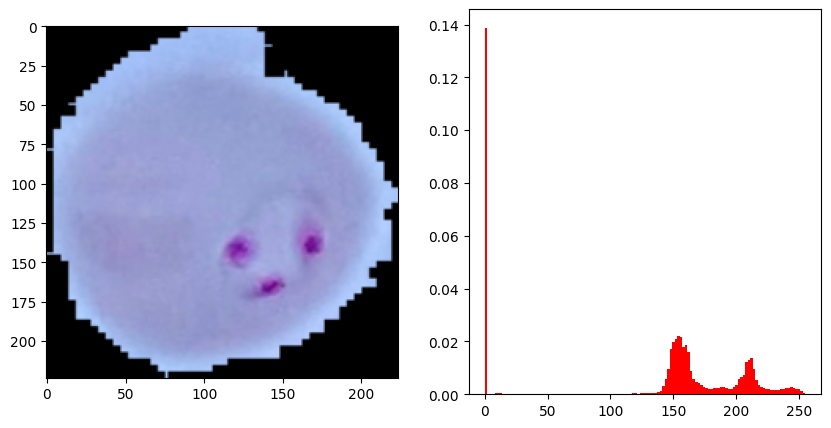

In [56]:
img = cv2.imread('FESI/Progetto/malaria/malaria/parasite (1).png', cv2.IMREAD_UNCHANGED)
resized = cv2.resize(img, (224, 224))

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(resized)


plt.subplot(1,2,2) 
plt.hist(resized.ravel(), bins=128, density=True, color='r')

plt.show()

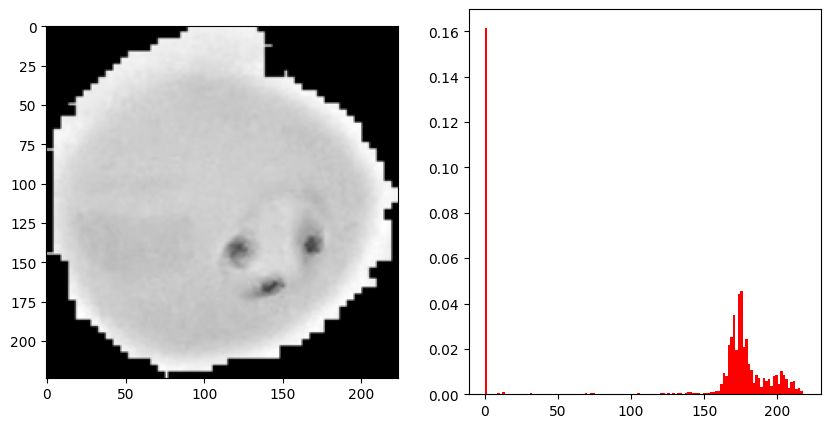

In [57]:
# Grayscale
img_gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(img_gray, cmap='gray')


plt.subplot(1,2,2) 
plt.hist(img_gray.ravel(), bins=128, density=True, color='r');

plt.show()

Cerco di applicare una sogliatura --> devo scegliere un valore adeguato per la soglia, altrimenti potrebbe capitare che se la soglia è troppo bassa, quasi tutti i pixel supereranno questo valore e l'immagine risultante sarà quasi completamente bianca.
Un idea puó essere applicare una prima sogliatura all'immagine ed ottenere una sorta di "maschera" per separare l'immagine dallo sfondo  

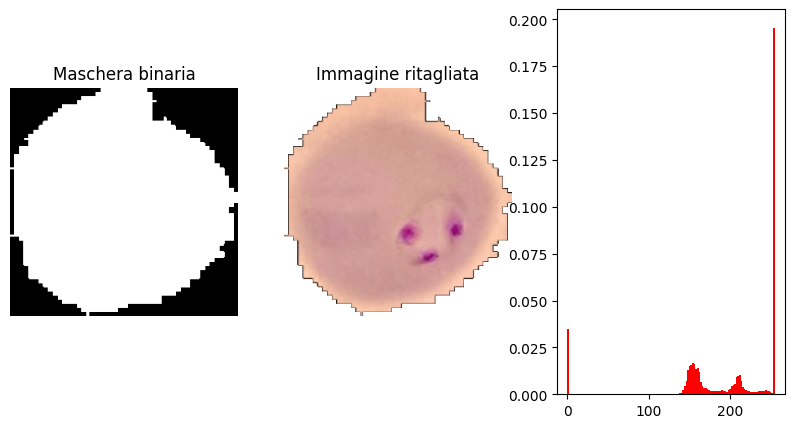

In [58]:
# Creo una maschera per rilevare il contenuto non nero
_, mask = cv2.threshold(img_gray, 10, 255, cv2.THRESH_BINARY)

# Sostituisci lo sfondo nero con bianco
resized_rgba = cv2.cvtColor(resized, cv2.COLOR_BGR2RGBA)

result = resized_rgba.copy()
result[mask == 0] = [255,255,255,0]   # seleziona tutti i pixel che corrispondono a dove mask è 0 e li metto bianchi
 
cv2.imwrite('FESI/Progetto/tests/image_cropped.png', result)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(mask, cmap='gray')
plt.title("Maschera binaria")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(result)
plt.title("Immagine ritagliata")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.hist(result.ravel(), bins=128, density=True, color='r');

plt.show()

Tramite una prima sogliatura ho quindi creato una maschera che ho sfruttato per separare l'immagine dallo sfondo.
Adesso procedo ...

N.B. --> durante la conversione in scala di grigi il canale alfa (che gestisce la trasparenza) viene perso, di conseguenza lo sfondo torna al suo colore originario (io ho impostato bianco)
posso evitare che ciò succeda conservando il canale alfa, e riapplicandolo all'immagine convertita. 
Tuttavia la funzione cv2.equalizeHist accetta solo immagini a un singolo canale (grayscale), di conseguenza non posso passare come argomento  un'immagine con due canali (grigio + alfa), che non perchè supportata da equalizeHist.

SOL --> effettuo prima l'equalizzazione unicamente sul canale grigio, e in seguito applico anche il canale alfa separatamente 

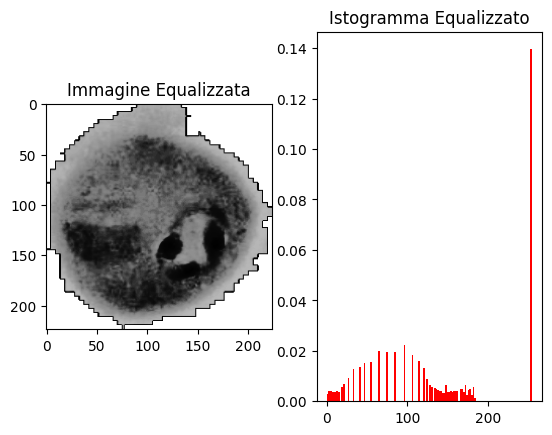

In [59]:
# Separo i quattro canali RGBA
b, g, r, alpha = cv2.split(result)

#converto l'immagine in scala di grigi + canale alfa
resultGray = cv2.cvtColor(cv2.merge((b, g, r)), cv2.COLOR_BGR2GRAY)

# Equalizzazione dell'istogramma sul canale grigio
eq_img = cv2.equalizeHist(resultGray)

# Ricombina il canale grigio equalizzato con il canale alfa originale
resultGray_noBg = cv2.merge((eq_img, alpha))
# Espandi il canale grigio in 3 canali
bgr_gray = cv2.merge((eq_img, eq_img, eq_img))

# Combina con il canale alfa
bgra_gray = cv2.merge((eq_img, eq_img, eq_img, alpha))

# Salva l'immagine con 4 canali (BGRA)
cv2.imwrite('FESI/Progetto/tests/boh.png', bgra_gray)

# Visualizza i risultati
plt.subplot(1, 2, 1)
plt.imshow(eq_img, cmap='gray')
plt.title("Immagine Equalizzata")

plt.subplot(1, 2, 2)
plt.hist(eq_img.ravel(), bins=128, density=True, color='r')
plt.title("Istogramma Equalizzato")
plt.show()